# **Load Dataset**

In [1]:
!pip install torch torchvision

In [2]:
import torch
print(torch.__version__)


2.1.0+cu121


In [3]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00


In [4]:
import torch
from torch_geometric.datasets import Planetoid


# Load the CiteSeer dataset
citeseer_dataset = Planetoid(root='', name='CiteSeer')

citeseer = citeseer_dataset[0]

Processing...
Done!


# **Split dataset**

In [6]:
from torch_geometric.transforms import RandomNodeSplit

transform = RandomNodeSplit(num_train_per_class=int(citeseer.num_nodes * 0.7), num_val=int(citeseer.num_nodes * 0.1), num_test=int(citeseer.num_nodes * 0.2))
citeseer = transform(citeseer)

# **Re-normalization Adjacency Matrix**

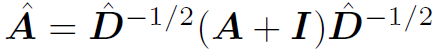

In [7]:
import numpy as np
import scipy.sparse as sp


def renormalize_adjacency(adj):
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] =  0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return (sp.eye(adj.shape[0]) + d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)).tocoo()

# **DropEdge technique**

image.png

In [8]:
import torch

def calculate_A_drop(adj_matrix, deletion_rate):

    edge_indices = torch.nonzero(adj_matrix, as_tuple=False)

    total_edges = len(edge_indices)

    num_edges_to_delete = int(total_edges * deletion_rate)


    permuted_indices = torch.randperm(total_edges)

    # first num_edges_to_delete indices
    indices_to_delete = edge_indices[permuted_indices[:num_edges_to_delete]]

    # Create a copy of adjacency matrix
    modified_adj_matrix = adj_matrix.clone()
    t =0
    # Delete selected edges
    for i, j in indices_to_delete:

        modified_adj_matrix[i, j] = 0

    return modified_adj_matrix




# **Important functions**

In [9]:
def train(model, optimizer, criterion, data, adjacency_matrix):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, adjacency_matrix)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out = model(data.x, adjacency_matrix)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out = model(data.x, adjacency_matrix)
        _, pred = torch.max(out, dim=1)
        correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / data.test_mask.sum().item()
    return acc


In [10]:
import torch
from torch_geometric.utils import to_dense_adj

edge_index = citeseer.edge_index

#edge index to adjacency matrix
adjacency_matrix = to_dense_adj(edge_index)[0]

In [11]:
A_drop = calculate_A_drop(adjacency_matrix , 0.1)

# **Eight layer GCN (With drop edge)**

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import math

class GCNLayer_with_drop_edge(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.0):
        super(GCNLayer_with_drop_edge, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()
        self.dropout = nn.Dropout(p=dropout)

    def reset_parameters(self):
        stdv =   1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adjacency_matrix):
        # Renormalize the adjacency matrix
        adjacency_matrix = renormalize_adjacency(adjacency_matrix.numpy())

        # Convert the renormalized adjacency matrix back to a PyTorch tensor
        adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float32)

        support = torch.mm(input, self.weight)
        output = torch.spmm(adjacency_matrix, support)
        if self.training:
            output = self.dropout(output)
        return output




In [17]:
class EightLayerGCN_with_drop_edge(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super(EightLayerGCN_with_drop_edge, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer_with_drop_edge(in_features, hidden_features, dropout)) #first
        for _ in range(6):
            self.layers.append(GCNLayer_with_drop_edge(hidden_features, hidden_features, dropout)) # 6 hidden

        self.layers.append(GCNLayer_with_drop_edge(hidden_features, out_features, dropout)) # last

    def forward(self, input, adjacency_matrix):
        x = input
        for layer in self.layers[:-1]:  # All layers except the last one
            A_drop = calculate_A_drop(adjacency_matrix , 0.4)
            x = F.relu(layer(x, A_drop))
        A_drop = calculate_A_drop(adjacency_matrix , 0.4)
        x = self.layers[-1](x, A_drop)  # Layer wise edge drop
        return x

## **Evaluation on citeseer**

In [19]:
import torch.optim as optim
torch.manual_seed(1)
model = EightLayerGCN_with_drop_edge(in_features =citeseer.num_node_features, hidden_features = 32 , out_features = citeseer_dataset.num_classes ,dropout= 0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5
min_delta = 0.001
patience_counter = 0
best_loss = float('inf')

# Train the best model
for epoch in range(200):
    A_drop = calculate_A_drop(adjacency_matrix , 0.1)
    train_loss = train(model, optimizer, criterion, citeseer , A_drop)
    val_loss = validate(model, criterion, citeseer , adjacency_matrix)

    # Check for improvement in validation loss
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch} \n')
            break


    print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} ')

# Evaluate the model
test_accuracy = test(model, criterion, citeseer , adjacency_matrix)
print(f'Test Accuracy(eight layer) on citeseer dataset: {test_accuracy:.4f}')

<ipython-input-7-ab0d944f8892>:8: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(row_sum, -0.5).flatten()


 Epoch: 0, Train Loss: 1.7969, Validation Loss: 1.7124 
 Epoch: 1, Train Loss: 1.7595, Validation Loss: 1.6825 
 Epoch: 2, Train Loss: 1.7174, Validation Loss: 1.6289 
 Epoch: 3, Train Loss: 1.6541, Validation Loss: 1.5571 
 Epoch: 4, Train Loss: 1.5842, Validation Loss: 1.4527 
 Epoch: 5, Train Loss: 1.4776, Validation Loss: 1.4946 
 Epoch: 6, Train Loss: 1.4216, Validation Loss: 1.3583 
 Epoch: 7, Train Loss: 1.3189, Validation Loss: 1.3917 
 Epoch: 8, Train Loss: 1.3187, Validation Loss: 1.3580 
 Epoch: 9, Train Loss: 1.2888, Validation Loss: 1.2878 
 Epoch: 10, Train Loss: 1.1814, Validation Loss: 1.2611 
 Epoch: 11, Train Loss: 1.1760, Validation Loss: 1.2455 
 Epoch: 12, Train Loss: 1.1588, Validation Loss: 1.2851 
 Epoch: 13, Train Loss: 1.1165, Validation Loss: 1.2462 
 Epoch: 14, Train Loss: 1.0918, Validation Loss: 1.1025 
 Epoch: 15, Train Loss: 1.0820, Validation Loss: 1.1203 
 Epoch: 16, Train Loss: 1.0623, Validation Loss: 1.1983 
 Epoch: 17, Train Loss: 1.0303, Validatio

## **analyze oversmoothing on 8-layer gcn**

In [23]:
class EightLayerGCN_with_drop_edge(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super(EightLayerGCN_with_drop_edge, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer_with_drop_edge(in_features, hidden_features, dropout))
        for _ in range(6):
            self.layers.append(GCNLayer_with_drop_edge(hidden_features, hidden_features, dropout))
        self.layers.append(GCNLayer_with_drop_edge(hidden_features, out_features, dropout))

    def forward(self, input, adjacency_matrix):
        x = input
        layer_outputs = []
        for layer in self.layers[:-1]:  # All layers except the last one
            A_drop = calculate_A_drop(adjacency_matrix , 0.4)
            x = F.relu(layer(x, A_drop))

            layer_outputs.append(x)
        A_drop = calculate_A_drop(adjacency_matrix , 0.4) # layer wise EDGE_drop
        x = self.layers[-1](x, A_drop)
        layer_outputs.append(x)
        return x, layer_outputs


In [24]:
import torch.autograd

torch.autograd.set_detect_anomaly(True)

def train_with_get_layer_outputs(model, optimizer, criterion, data, adjacency_matrix):
    model.train()
    optimizer.zero_grad()
    out , layer_outputs = model(data.x, adjacency_matrix)  # Pass the adjacency matrix to the model
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item() , layer_outputs

def validate_with_layer_outputs(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out , _ = model(data.x, adjacency_matrix)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test_with_layer_outputs(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out , _ = model(data.x, adjacency_matrix)
        _, pred = torch.max(out, dim=1)
        correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / data.test_mask.sum().item()
    return acc


In [25]:
torch.manual_seed(1)

# Training loop
all_layer_outputs = []

distances_before_train = []
distances_after_train = []
model = EightLayerGCN_with_drop_edge(in_features =citeseer.num_node_features, hidden_features = 32 , out_features = citeseer_dataset.num_classes ,dropout= 0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


output, layer_outputs = model(citeseer.x, A_drop)
all_layer_outputs.append(layer_outputs) # save layer output before train


for epoch in range(150):
    A_drop = calculate_A_drop(adjacency_matrix , 0.1)
    train_loss , layer_outputs = train_with_get_layer_outputs(model, optimizer, criterion, citeseer , A_drop)
    print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f} ')

output, layer_outputs = model(citeseer.x, A_drop)
all_layer_outputs.append(layer_outputs) # save layer output after train




<ipython-input-7-ab0d944f8892>:8: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(row_sum, -0.5).flatten()


 Epoch: 0, Train Loss: 1.7971 
 Epoch: 1, Train Loss: 1.7550 
 Epoch: 2, Train Loss: 1.7218 
 Epoch: 3, Train Loss: 1.6727 
 Epoch: 4, Train Loss: 1.5980 
 Epoch: 5, Train Loss: 1.5434 
 Epoch: 6, Train Loss: 1.4346 
 Epoch: 7, Train Loss: 1.3987 
 Epoch: 8, Train Loss: 1.3565 
 Epoch: 9, Train Loss: 1.3222 
 Epoch: 10, Train Loss: 1.2816 
 Epoch: 11, Train Loss: 1.2642 
 Epoch: 12, Train Loss: 1.1757 
 Epoch: 13, Train Loss: 1.1824 
 Epoch: 14, Train Loss: 1.1412 
 Epoch: 15, Train Loss: 1.1174 
 Epoch: 16, Train Loss: 1.0957 
 Epoch: 17, Train Loss: 1.0766 
 Epoch: 18, Train Loss: 1.0372 
 Epoch: 19, Train Loss: 1.0389 
 Epoch: 20, Train Loss: 1.0131 
 Epoch: 21, Train Loss: 1.0167 
 Epoch: 22, Train Loss: 0.9733 
 Epoch: 23, Train Loss: 0.9775 
 Epoch: 24, Train Loss: 0.9763 
 Epoch: 25, Train Loss: 0.9509 
 Epoch: 26, Train Loss: 0.9341 
 Epoch: 27, Train Loss: 0.9073 
 Epoch: 28, Train Loss: 0.9210 
 Epoch: 29, Train Loss: 0.8941 
 Epoch: 30, Train Loss: 0.8687 
 Epoch: 31, Train 

In [28]:
import matplotlib.pyplot as plt

def plot_mean_distances(all_layer_outputs, start_index=2, end_index=7):
    distances = []
    distances_before_train = []
    distances_after_train = []
    layer_outputs_before_train = all_layer_outputs[0]

    layer_outputs_after_train = all_layer_outputs[-1]

    for i in range(1 , 6):

        layer1 = layer_outputs_before_train[i]
        layer2 = layer_outputs_before_train[i+1]
        distance = torch.cdist(layer1, layer2, p=2)
        mean_distance = distance.mean().item()
        distances_before_train.append(mean_distance)


    for i in range(1 , 6):

        layer1 = layer_outputs_after_train[i]
        layer2 = layer_outputs_after_train[i+1]
        distance = torch.cdist(layer1, layer2, p=2)
        mean_distance = distance.mean().item()
        distances_after_train.append(mean_distance)
    print(distances_before_train)
    print(distances_after_train)
    # Plotting the mean distances
    plt.figure(figsize=(15,  6))
    plt.semilogy(range(start_index, end_index), distances_before_train, marker='o', label='Before Training')
    plt.semilogy(range(start_index, end_index), distances_after_train, marker='o', label='After Training(after 150 epoch)')
    plt.title('Mean Euclidean Distances Between Consecutive Layers')
    plt.xlabel('Layer')
    plt.ylabel('Mean Distance')
    plt.xticks(range(start_index, end_index))
    plt.legend()  # Added legend to distinguish between before and after training
    plt.grid(True)
    plt.show()

[1.6609469652175903, 1.3601055145263672, 0.9053160548210144, 0.6943444013595581, 0.5113979578018188]
[5.193873882293701, 9.422052383422852, 17.31721305847168, 28.869070053100586, 41.13766860961914]


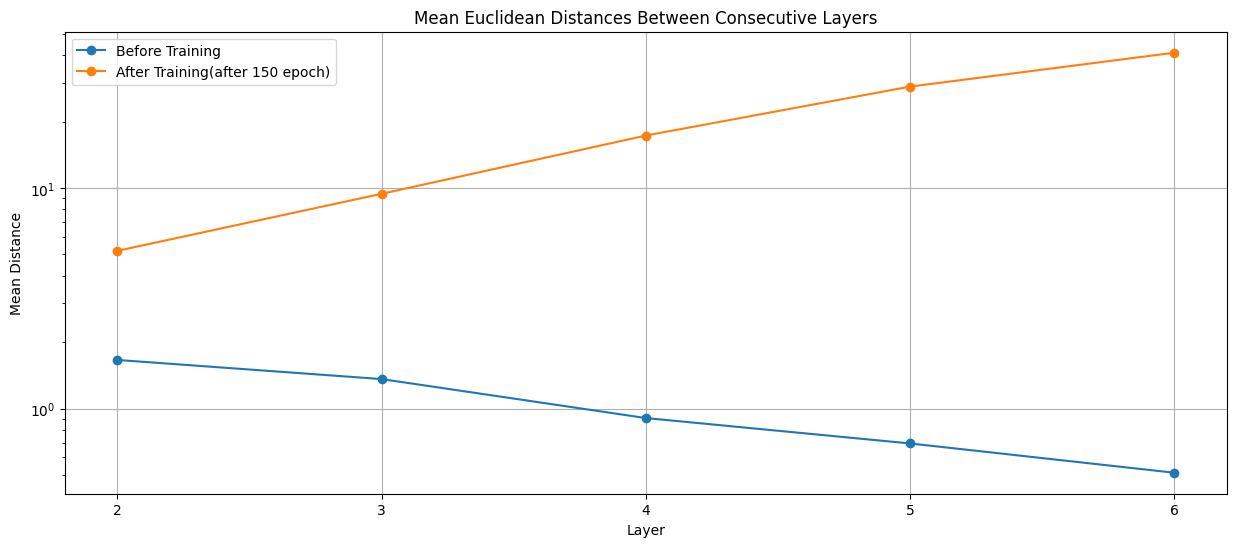

In [29]:
plot_mean_distances(all_layer_outputs)